In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(12345)

from lymph.models import Unilateral
from lymixture import LymphMixture
from lymixture.utils import binom_pmf, late_binomial, normalize

dataset = pd.read_csv('../../data/mixture_model_data_combined.csv', header = [0,1,2],)
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'uniform')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'uniform')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]

In [2]:
dataset_staging_main_groups = dataset_staging.copy()

# Reduce to only main subsite
dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()
dataset_selected = dataset_staging_main_groups.loc[dataset_staging_main_groups['tumor']['1']['subsite'].isin(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10'])]
dataset_selected

patient                            \
                                     #                             
                           institution     sex age diagnose_date   
219         University Hospital Zurich    male  59    2017-08-30   
220         University Hospital Zurich  female  75    2017-10-25   
221         University Hospital Zurich    male  87    2018-04-03   
222         University Hospital Zurich    male  87    2018-04-16   
223         University Hospital Zurich  female  70    2018-05-25   
...                                ...     ...  ..           ...   
1630  Vall d'Hebron Barcelona Hospital    MALE  69    2020-04-09   
1631  Vall d'Hebron Barcelona Hospital    MALE  76    2014-12-02   
1632  Vall d'Hebron Barcelona Hospital  FEMALE  52    2016-01-18   
1633  Vall d'Hebron Barcelona Hospital  FEMALE  56    2016-05-12   
1634  Vall d'Hebron Barcelona Hospital  FEMALE  67    2016-04-13   

                                                                         \
                                                                          
     alcohol_abuse nicotine_abuse pack_years hpv_status neck_dissection   
219           True           True        NaN       True           False   
220          False          False        NaN       True           False   
221          False           True        NaN       True           False   
222           True           True        NaN      False           False   
223           True           True        NaN       True           False   
...            ...            ...        ...        ...             ...   
1630         False           True        NaN      False           False   
1631         False          False        NaN       True           False   
1632         False           True        NaN      False           False   
1633         False           True        NaN       True           False   
1634         False           True        NaN      False           False   

                  ... positive_dissected        enbloc_dissected              \
                  ...               ipsi contra             ipsi      contra   
     tnm_edition  ...                  I      I              III   IV    III   
219            8  ...                NaN    NaN              NaN  NaN    NaN   
220            8  ...                NaN    NaN              NaN  NaN    NaN   
221            7  ...                NaN    NaN              NaN  NaN    NaN   
222            8  ...                NaN    NaN              NaN  NaN    NaN   
223            7  ...                NaN    NaN              NaN  NaN    NaN   
...          ...  ...                ...    ...              ...  ...    ...   
1630           8  ...                NaN    NaN              NaN  NaN    NaN   
1631           7  ...                NaN    NaN              NaN  NaN    NaN   
1632           7  ...                NaN    NaN              NaN  NaN    NaN   
1633           7  ...                NaN    NaN              NaN  NaN    NaN   
1634           7  ...                NaN    NaN              NaN  NaN    NaN   

          enbloc_positive                   
                     ipsi      contra       
       IV             III   IV    III   IV  
219   NaN             NaN  NaN    NaN  NaN  
220   NaN             NaN  NaN    NaN  NaN  
221   NaN             NaN  NaN    NaN  NaN  
222   NaN             NaN  NaN    NaN  NaN  
223   NaN             NaN  NaN    NaN  NaN  
...   ...             ...  ...    ...  ...  
1630  NaN             NaN  NaN    NaN  NaN  
1631  NaN             NaN  NaN    NaN  NaN  
1632  NaN             NaN  NaN    NaN  NaN  
1633  NaN             NaN  NaN    NaN  NaN  
1634  NaN             NaN  NaN    NaN  NaN  

[1242 rows x 224 columns]

In [3]:
graph = {
    ("tumor", "T"): ["I", "II", "III", "IV"],
    ("lnl", "I"): ["II"],
    ("lnl", "II"): ["III"],
    ("lnl", "III"): ["IV"],
    ("lnl", "IV"): [],
}

num_components = 2

mixture = LymphMixture(
    model_cls=Unilateral,
    model_kwargs={"graph_dict": graph},
    num_components=num_components,
    universal_p= False
)
mixture.load_patient_data(
    dataset_selected,
    split_by=("tumor", "1", "subsite"),
    mapping=lambda x: x,
)


In [4]:
mixture.set_distribution("uniform", binom_pmf(np.arange(11), 10, 0.3))
# mixture.set_distribution("late", late_binomial)
mixture.set_modality("diagnostic_consensus", 1., 1.)

In [5]:
mixture.subgroups.keys()

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10'])

Initialize random model parameters and latent variables/responsibilities.

In [6]:
from lymixture.em import expectation, maximization

params = {k: rng.uniform() for k in mixture.get_params()}

mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [7]:
def to_numpy(params: dict[str, float]) -> np.ndarray:
    return np.array([p for p in params.values()])

Iterate the computation of the expectation value of the latent variables (E-step) and the maximization of the (complete) data log-likelihood w.r.t. the model parameters (M-step).

In [8]:
def check_convergence(params_history, likelihood_history, steps_back_list):
    current_params = params_history[-1]
    current_likelihood = likelihood_history[-1]
    for steps_back in steps_back_list:
        previous_params = params_history[-steps_back - 1]
        if np.allclose(to_numpy(current_params), to_numpy(previous_params)):
            print('stopped due to parameter similarity')
            return True  # Return True if any of the steps is close
        elif (np.isclose(current_likelihood, likelihood_history[-steps_back - 1])) and np.all(current_likelihood <= np.array(likelihood_history)):
            print('stopped due to likelihood similarity')
            return True
    return False

In [9]:
from lymixture.em import _get_params
(len(mixture.components)-1) * len(mixture.subgroups)
_get_params(mixture)

array([ 0.22733602,  0.31675834,  0.79736546,  0.67625467,  0.39110955,
        0.33281393,  0.59830875,  0.88647992,  0.6974535 ,  0.32647286,
        0.73392816,  0.22013496,  0.08159457,  0.1598956 ,  0.5995541 ,
       -0.36893007, -1.26271811,  1.18972126, -1.5910692 , -1.63970393,
       -0.04514654,  0.30359309])

In [10]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10
0,0.354446,0.5912,0.779494,0.233309,0.830766,0.837495,0.511285,0.424679
1,0.645554,0.4088,0.220506,0.766691,0.169234,0.162505,0.488715,0.575321


In [11]:
is_converged = False
count = 0
params_history = []
likelihood_history = []
params_history.append(params.copy())
likelihood_history.append(mixture.likelihood(use_complete = False))
# Number of steps to look back for convergence
look_back_steps = 3

while not is_converged:
    print(count)
    print(likelihood_history[-1])
    old_params = params
    latent = expectation(mixture, params)
    params = maximization(mixture, latent)
    print('old_params', mixture.likelihood(use_complete=True, given_params = old_params))
    print('new params', mixture.likelihood(use_complete=True, given_params = params))
    
    # Append current params and likelihood to history
    params_history.append(params.copy())
    likelihood_history.append(mixture.likelihood(use_complete=False))
    
    # Check if converged
    if count >= 3:  # Ensure enough history is available
        is_converged = check_convergence(params_history, likelihood_history,list(range(1,look_back_steps+1)))
    count += 1

0
-5820.126993966002
old_params -6468.445413030839
new params -2948.1504221908644
1
-2265.913861457545
old_params -2997.144979311548
new params -2986.8068864747374
2
-2248.970231712355
old_params -3000.6755338013973
new params -2995.3198624118813
3
-2238.4545837735395
old_params -2990.3575474242307
new params -2984.7052331899736
4
-2226.5261459378607
old_params -2961.645548318542
new params -2954.007702438923
5
-2210.270284788936
old_params -2910.109265656415
new params -2899.3701588312374
6
-2187.872625225799
old_params -2831.789252338287
new params -2817.746316298164
7
-2159.6008299146342
old_params -2728.5086271962373
new params -2713.4815950519237
8
-2131.348977484645
old_params -2620.405590973186
new params -2608.1173114391013
9
-2110.0183854789257
old_params -2530.6270649858357
new params -2523.6602228093357
10
-2098.736564683361
old_params -2472.727370507585
new params -2469.886829696007
11
-2094.2859142558295
old_params -2441.441521226225
new params -2440.4310987718704
12
-2092

In [12]:
mixture.get_params()

{'0_TtoI_spread': 0.037467202498109586,
 '0_TtoII_spread': 0.5074111756957973,
 '0_TtoIII_spread': 0.10088442465934132,
 '0_TtoIV_spread': 0.010958406371705177,
 '0_ItoII_spread': 0.999939074260419,
 '0_IItoIII_spread': 0.08979510321182868,
 '0_IIItoIV_spread': 0.1886492257260483,
 '0_C01_coef': 0.9999999999838132,
 '0_C02_coef': 0.300198197627148,
 '0_C03_coef': 1.403805026744085e-17,
 '0_C04_coef': 0.12167587681491947,
 '0_C05_coef': 0.4481632706790238,
 '0_C06_coef': 0.09117262155154338,
 '0_C09_coef': 0.8948624240373958,
 '0_C10_coef': 0.748399271918621,
 '1_TtoI_spread': 0.08150330290590138,
 '1_TtoII_spread': 0.03353383191298248,
 '1_TtoIII_spread': 0.02751271017192861,
 '1_TtoIV_spread': 0.0073934380104715355,
 '1_ItoII_spread': 0.3286600287668772,
 '1_IItoIII_spread': 0.06184428900257007,
 '1_IIItoIV_spread': 6.610696135189607e-05,
 '1_C01_coef': 1.6186866405333145e-11,
 '1_C02_coef': 0.6998018023728519,
 '1_C03_coef': 1.0,
 '1_C04_coef': 0.8783241231850806,
 '1_C05_coef': 0.55

In [13]:
likelihood_history

[-5820.126993966002,
 -2265.913861457545,
 -2248.970231712355,
 -2238.4545837735395,
 -2226.5261459378607,
 -2210.270284788936,
 -2187.872625225799,
 -2159.6008299146342,
 -2131.348977484645,
 -2110.0183854789257,
 -2098.736564683361,
 -2094.2859142558295,
 -2092.682236468137,
 -2092.024246247057,
 -2091.695038128091,
 -2091.4989808444448,
 -2091.357240562642,
 -2091.244054147137,
 -2091.148197316822,
 -2091.063961154048,
 -2090.9882050082597,
 -2090.9190458384937,
 -2090.855257231846,
 -2090.7959760180165,
 -2090.740695249758,
 -2090.6890096997026,
 -2090.640302718118,
 -2090.5946284443,
 -2090.5518031291995,
 -2090.5115992807687,
 -2090.4738279129015,
 -2090.438378857639,
 -2090.4050622000013,
 -2090.3738512604805,
 -2090.344692151613,
 -2090.317428834125,
 -2090.291913625886,
 -2090.2682353049827,
 -2090.246116851499,
 -2090.2254382798255,
 -2090.2063747772,
 -2090.1886566663543,
 -2090.172230587845,
 -2090.157009109466,
 -2090.1429190369918,
 -2090.129684136273,
 -2090.117461342841

In [15]:
mixture.likelihood(use_complete=False)

-2089.985937262486

In [16]:
params

{'0_TtoI_spread': 0.037467202498109586,
 '0_TtoII_spread': 0.5074111756957973,
 '0_TtoIII_spread': 0.10088442465934132,
 '0_TtoIV_spread': 0.010958406371705177,
 '0_ItoII_spread': 0.999939074260419,
 '0_IItoIII_spread': 0.08979510321182868,
 '0_IIItoIV_spread': 0.1886492257260483,
 '0_C01_coef': 0.9999999999838132,
 '0_C02_coef': 0.300198197627148,
 '0_C03_coef': 1.403805026744085e-17,
 '0_C04_coef': 0.12167587681491947,
 '0_C05_coef': 0.4481632706790238,
 '0_C06_coef': 0.09117262155154338,
 '0_C09_coef': 0.8948624240373958,
 '0_C10_coef': 0.748399271918621,
 '1_TtoI_spread': 0.08150330290590138,
 '1_TtoII_spread': 0.03353383191298248,
 '1_TtoIII_spread': 0.02751271017192861,
 '1_TtoIV_spread': 0.0073934380104715355,
 '1_ItoII_spread': 0.3286600287668772,
 '1_IItoIII_spread': 0.06184428900257007,
 '1_IIItoIV_spread': 6.610696135189607e-05,
 '1_C01_coef': 1.6186866405333145e-11,
 '1_C02_coef': 0.6998018023728519,
 '1_C03_coef': 1.0,
 '1_C04_coef': 0.8783241231850806,
 '1_C05_coef': 0.55

In [17]:
mixture._mixture_coefs

,C01,C02,C03,C04,C05,C06,C09,C10
0,1.000000e+00,0.300198,1.403805e-17,0.121676,0.448163,0.091173,0.894862,0.748399
1,1.618687e-11,0.699802,1.000000e+00,0.878324,0.551837,0.908827,0.105138,0.251601


In [18]:
mixture.get_params()

{'0_TtoI_spread': 0.037467202498109586,
 '0_TtoII_spread': 0.5074111756957973,
 '0_TtoIII_spread': 0.10088442465934132,
 '0_TtoIV_spread': 0.010958406371705177,
 '0_ItoII_spread': 0.999939074260419,
 '0_IItoIII_spread': 0.08979510321182868,
 '0_IIItoIV_spread': 0.1886492257260483,
 '0_C01_coef': 0.9999999999838132,
 '0_C02_coef': 0.300198197627148,
 '0_C03_coef': 1.403805026744085e-17,
 '0_C04_coef': 0.12167587681491947,
 '0_C05_coef': 0.4481632706790238,
 '0_C06_coef': 0.09117262155154338,
 '0_C09_coef': 0.8948624240373958,
 '0_C10_coef': 0.748399271918621,
 '1_TtoI_spread': 0.08150330290590138,
 '1_TtoII_spread': 0.03353383191298248,
 '1_TtoIII_spread': 0.02751271017192861,
 '1_TtoIV_spread': 0.0073934380104715355,
 '1_ItoII_spread': 0.3286600287668772,
 '1_IItoIII_spread': 0.06184428900257007,
 '1_IIItoIV_spread': 6.610696135189607e-05,
 '1_C01_coef': 1.6186866405333145e-11,
 '1_C02_coef': 0.6998018023728519,
 '1_C03_coef': 1.0,
 '1_C04_coef': 0.8783241231850806,
 '1_C05_coef': 0.55

In [19]:
subgroup = 'C03'
t_stage = 'uniform'
desired_lnl = 'II'
lnls = np.array(['I','II','III','IV'])
involvement = {'I': None, 'II': None, 'III': None, 'IV': None}



subgroup_combinations_short = pd.DataFrame(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].loc[mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage].value_counts()/((mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage) & (np.all(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].notna(),axis = 1))).sum().sum())
# Convert the Series to DataFrame
df = subgroup_combinations_short.reset_index()
df.columns = ['I', 'II', 'III', 'IV', 'prevalence']

# Convert boolean columns to tuples
df['predicted'] = df[['I', 'II', 'III', 'IV']].apply(lambda row: tuple(int(x) for x in row), axis=1)

# Drop the original boolean columns
df = df.drop(columns=['I', 'II', 'III', 'IV'])

import itertools

# Define the number of features (length of the combination list)
num_features = 4  # Update based on your data length

# Generate all possible combinations of binary values (0 or 1)
combinations = list(itertools.product([0, 1], repeat=num_features))

# Create a DataFrame with all combinations and default probability of 0
subgroup_combinations = pd.DataFrame(combinations, columns=[f'Feature_{i+1}' for i in range(num_features)])
subgroup_combinations['predicted'] = subgroup_combinations.apply(lambda row: tuple(row), axis=1)
subgroup_combinations.drop(columns=[f'Feature_{i+1}' for i in range(num_features)], inplace=True)
# Merge with the existing probabilities
subgroup_combinations = pd.merge(subgroup_combinations, df, on='predicted', how='left').fillna(0)
subgroup_combinations.drop(columns=['predicted'], inplace=True)

mixture.state_dist(subgroup=subgroup,t_stage='uniform')
df = pd.DataFrame(np.array([mixture.state_dist(subgroup=subgroup,t_stage=t_stage)]), columns = [str(col) for col in mixture.components[0].graph.state_list])
df = df.T
df.columns = ['predicted']
subgroup_combinations['index'] = df.index
subgroup_combinations.set_index('index', inplace=True)
df_final = pd.concat([subgroup_combinations, df],axis = 1)
df_final['difference'] = df_final['predicted'] - df_final['prevalence']

lnl_index = np.where(lnls == desired_lnl)[0][0]
indices = []
for i, state in enumerate(mixture.components[0].graph.state_list):
    if state[lnl_index] == 1:
        indices.append(i)
print(desired_lnl, subgroup_combinations.iloc[indices].sum()*100,)
involvement[desired_lnl] = True
print('predicted involvement of', desired_lnl, mixture.risk(subgroup=subgroup, t_stage=t_stage, involvement=involvement)*100)

(df_final*100)

II prevalence    20.0
dtype: float64
predicted involvement of II 16.440732829156023


,prevalence,predicted,difference
[0 0 0 0],57.777778,64.479863,6.702085
[0 0 0 1],0.000000,1.301700,1.301700
[0 0 1 0],0.000000,5.070364,5.070364
[0 0 1 1],0.000000,0.131886,0.131886
[0 1 0 0],4.444444,5.800950,1.356506
[0 1 0 1],0.000000,0.148146,0.148146
[0 1 1 0],0.000000,1.104389,1.104389
[0 1 1 1],0.000000,0.033913,0.033913
[1 0 0 0],22.222222,11.221328,-11.000894
[1 0 0 1],0.000000,0.269844,0.269844


## Load/Save Data

In [28]:
import pickle 

# with open('params_I_to_IV_ipsi_2_comp_split_t_stage_combined_ICCR_new.pkl', 'wb') as f:
#     pickle.dump(mixture.get_params(), f)
        
with open('params_I_to_IV_ipsi_2_comp_split_t_stage_combined_ICCR_new.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
params = loaded_dict
mixture.set_params(**loaded_dict)
mixture.normalize_mixture_coefs()
mixture.set_resps(expectation(mixture, loaded_dict))
mixture.likelihood(use_complete=False)

-2089.985937262486

In [22]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10
0,1.000000e+00,0.300198,1.403805e-17,0.121676,0.448163,0.091173,0.894862,0.748399
1,1.618687e-11,0.699802,1.000000e+00,0.878324,0.551837,0.908827,0.105138,0.251601


## Mixture evaluation

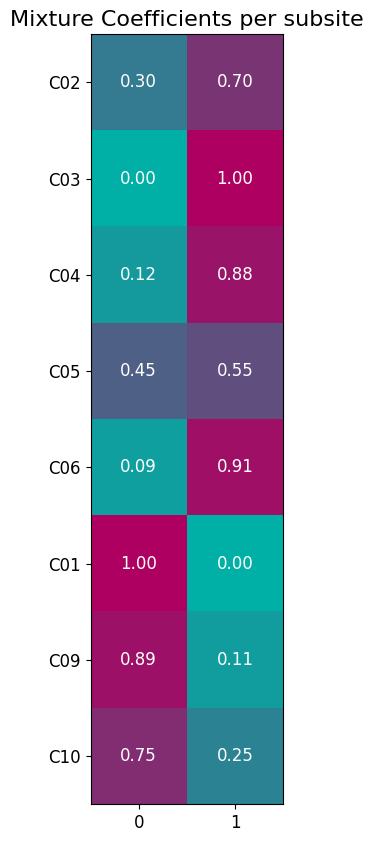

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)

matrix = mixture.get_mixture_coefs()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10']]

# Transpose the matrix to rotate by 90°
matrix_rotated = matrix.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Display the rotated matrix using imshow
cax = ax.imshow(matrix_rotated.values, cmap=tmp, origin='upper')

# Loop over the data and create text annotations
for i in range(matrix_rotated.shape[0]):  # Rows (previously columns)
    for j in range(matrix_rotated.shape[1]):  # Columns (previously rows)
        value = matrix_rotated.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                color="white", fontsize=12)


# Optional: Set axis labels and title
ax.set_xticks(range(matrix_rotated.shape[1]))
ax.set_xticklabels(matrix.index, fontsize = 12)  # Original row labels
ax.set_yticks(range(matrix_rotated.shape[0]))
ax.set_yticklabels(matrix.columns, fontsize = 12)  # Original column labels
ax.set_title("Mixture Coefficients per subsite", fontsize = 16)
plt.show()
